In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from scipy.interpolate import RectBivariateSpline
path = '../PostBornEma/'
sys.path.append("../scripts/") 
from lab import *

In [2]:
#general settings
bin_num = 'all'
# z_lens = 0.5
chimax  = chi_cmb

delta_lensing = True # set to False for galaxy lensing
gal_bin = None

if not delta_lensing:
    dn_filename = '../LSSTdndzs/dndz_LSST_i27_SN5_3y'
    if gal_bin is "all":
        zbin, nbin = np.load(dn_filename+'tot_extrapolated.npy',encoding='latin1')
        chi_low = min(1e-2,chi_z(min(zbin)))
        chi_hi  = chi_z(max(zbin))
    else:
        bins,big_grid,res   = np.load(dn_filename+'_extrapolated.npy',encoding='latin1')
        chi_low = max(chi_z(bins[gal_bin][0]-2*bins[gal_bin][2]),0.)
        if gal_bin<4:
            chi_hi  = chi_z(bins[gal_bin+1][0]+2.*bins[gal_bin+1][2])
        else:
            chi_hi  = chi_z(bins[gal_bin][0]+1.5)

if delta_lensing: 
    if chimax==chi_cmb:
        file_ext = 'lsst%s_cmblens'%str(bin_num)
    else:
        file_ext = 'lsst%s_deltalens_z%.0e'%str(bin_num,z_lens)
else:
    file_ext = 'lsst%s_lensbin_%s'%str(bin_num,gal_bin)

In [3]:
if delta_lensing:
    print('delta lensing with chimax %d'%chimax)
    def lensing_kernel(xi):
        xmax = chimax
        return (xmax - xi)/(xmax*xi) * (xmax > xi)
else:
    print('galaxy lensing with bin %s'%str(gal_bin))
    p_z_lens = dNdz_LSST(gal_bin)
    lensing_kernel = gal_lens(p_z_lens,chimin=max(1e-2,chi_low),chimax=chi_hi)
    

if bin_num == 'all':
    def lsst_kernel(x):
        return lsst_kernel_cb(x)*simple_bias(x)
else:
    def lsst_kernel(x):
        return lsst_kernel_cbn[bin_num](x)*simple_bias(x)

delta lensing with chimax 9414


### 1) Terms that also appear in Limber approximation

#### Collecting all contributions from Eq.s 4.2-4.5 that are also non-zero in Limber

Term 1:
$- \int_{\vec{l}} [\vec{L}\cdot \vec{l}] [\vec{l}\cdot (\vec{L}-\vec{l})]^2 \int \mathrm{d}\chi \int \mathrm{d}\chi' W(\chi,\chi_{CMB}) W^h(\chi') C_l^{\delta\psi}(\chi',\chi) C_{|\vec{L}-\vec{l}|}^{\phi\phi}(\chi',\chi) = - \int_{\vec{l}} [\vec{L}\cdot \vec{l}] [\vec{l}\cdot (\vec{L}-\vec{l})]^2 M^{A}(l,|\vec{L}-\vec{l}|)$
after  transform $\vec{l} \rightarrow \vec{l}+\vec{L}$

$\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2 M^{A}( |\vec{L}+\vec{l}|,l)$

Term 2: 
$ L^2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 \int \mathrm{d}\chi \int \mathrm{d}\chi' W(\chi,\chi_{CMB}) W^h(\chi') C_L^{\delta\psi}(\chi',\chi) [\frac{1}{2}C_{l}^{\phi\phi}(\chi')+\frac{1}{2}C_{l}^{\phi\phi}(\chi)]$
$ = L^2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 \tilde{M}^{A}(L,l)$

Comparison with Limber results suggest that we are missing a minus sign in Term 2. Will be coding with this Minus sign

Adding Term 1 and 2 with trick from Krause & Hirata:
$\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2 [M^{A}( |\vec{L}+\vec{l}|,l)-\tilde{M}^{A}(L,l)] +  \left[\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2-L^2[\vec{L}\cdot \vec{l}]^2\right] \tilde{M}^{A}(L,l)$


In [4]:
# naming corresponds to order of axes, files are clphiphi_VB_parallel_split.py and clphiphi_VB_parallel_split2.py
chi1s, chi2s, clphiphirt = np.load('../G_matrices/clphiphi_rt.npy')
chi1s_, chi2s_, clphiphir_over_t = np.load('../G_matrices/clphiphi_r_over_t.npy')
clphiphirt = np.swapaxes(clphiphirt,1,2)
clphiphir_over_t = np.swapaxes(clphiphir_over_t,1,2)

In [5]:
r2d, t2d = np.meshgrid(t_,t_)
#checking if axes of clphiphi are ordered correctly
print(np.swapaxes(chi2s,0,1)[0],(r2d*t2d*chi_cmb)[0])
print(np.swapaxes(chi2s_,0,1)[0],(r2d/t2d*chi_cmb)[0])

(array([  1.92887131e-04,   1.01610380e-03,   2.49628944e-03,
         4.63232690e-03,   7.42216945e-03,   1.08631008e-02,
         1.49517621e-02,   1.96841596e-02,   2.50556701e-02,
         3.10610455e-02,   3.76944181e-02,   4.49493067e-02,
         5.28186228e-02,   6.12946773e-02,   7.03691885e-02,
         8.00332899e-02,   9.02775388e-02,   1.01091926e-01,
         1.12465884e-01,   1.24388301e-01,   1.36847526e-01,
         1.49831387e-01,   1.63327196e-01,   1.77321768e-01,
         1.91801428e-01,   2.06752029e-01,   2.22158963e-01,
         2.38007175e-01,   2.54281181e-01,   2.70965080e-01,
         2.88042569e-01,   3.05496964e-01,   3.23311208e-01,
         3.41467898e-01,   3.59949291e-01,   3.78737330e-01,
         3.97813657e-01,   4.17159633e-01,   4.36756356e-01,
         4.56584678e-01,   4.76625225e-01,   4.96858415e-01,
         5.17264480e-01,   5.37823480e-01,   5.58515328e-01,
         5.79319806e-01,   6.00216586e-01,   6.21185250e-01,
         6.42205311e-01

### Coding the new equation for Term 1:
$\frac{\mathcal A}{2 \pi^2} \sum_n \int dr \chi_{cmb}^{-\nu} r^{-\nu-1} W(r \chi_{cmb},\chi_{cmb}) [1+z(r \chi_{cmb})] D(r \chi_{cmb})\int dt I^{(2)}(\nu_n, t)[ D(tr  \chi_{cmb})W_h(tr  \chi_{cmb}) C_{l1}^{\phi\phi}(tr  \chi_{cmb},r \chi_{cmb})+ t^\nu D(r/t  \chi_{cmb})W_h(r/t  \chi_{cmb}) C_{l1}^{\phi\phi}(r/t  \chi_{cmb},r \chi_{cmb}))]$

In [32]:
#getting MA Eq. 4.4

try: 
    _, M22a = np.load('../M_matrices/M22a_%s.npy'%file_ext)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    clphiphirt_ = np.expand_dims(clphiphirt,-1)
    clphiphir_over_t_ = np.expand_dims(clphiphir_over_t,-1)

    result = np.zeros((len(ell_),len(ell_)))



    n = 2

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)
        chi1fac0 = (lensing_kernel(r2d*chimax)*D_chi(r2d*chimax)*(1.+z_chi(r2d*chimax)))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (lsst_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*clphiphirt_[nn])
        chi2fac01 = (lsst_kernel(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax)*clphiphir_over_t_[nn])
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I2_ltrc[ii])

    print(time.time()-begin)

    M22a = chimax * result*1./np.pi**2/2.*prefac/4.
    np.save('../M_matrices/M22a_%s.npy'%str(file_ext),[np.meshgrid(ell_),M22a.T])

M22a_spline = RectBivariateSpline(ell_,ell_,MA22a)

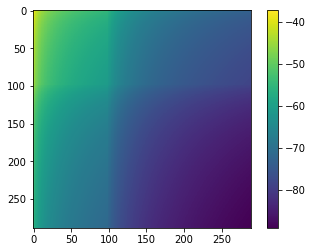

In [19]:
plt.imshow(np.log(MA22a))
plt.colorbar()

### clphiphi diag for term 2

In [20]:
# script: clphiphi_VB_parallel.py
clphiphi   = np.load('../G_matrices/clphiphi_parallel.npy')

cl_phiphi_diag= np.zeros((len(ell_),len(t_)))
for ii in range(len(t_)):
    cl_phiphi_diag[:,ii]=clphiphi[:,ii,ii]

clphiphi_diag=[]
from scipy.interpolate import interp1d
for ii in range(len(ell_)):
    clphiphi_diag+=[interp1d(chi_cmb*t_,cl_phiphi_diag[ii])]

In [21]:
#getting tilde MA Eq.4.3

#transpose of code
try:
    _, M31Aa = np.load('../M_matrices/M31Aa_%s.npy'%file_ext)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    result = np.zeros((len(ell_),len(ell_)))

    chimax  = chi_cmb

    n = 2

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)

        chi1fac0 = (lsst_kernel(r2d*chimax)*D_chi(r2d*chimax)*clphiphi_diag[nn](r2d*chimax))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (lensing_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*(1.+z_chi(r2d*t2d*chimax)))
        chi2fac01 = (lensing_kernel(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax)*(1.+z_chi(r2d/t2d*chimax)))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I2_ltrc[ii])

    print(time.time()-begin)

    M31Aa = chimax * result*1./np.pi**2/2.*prefac/4./2.

    np.save('../M_matrices/M31Aa_%s.npy'%file_ext,[np.meshgrid(ell_),M31Aa.T])

M31Aa_spline = RectBivariateSpline(ell_,ell_,M31Aa)

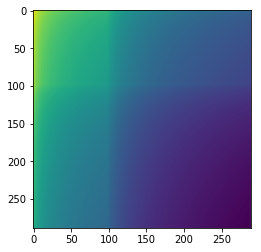

In [23]:

plt.imshow(np.log(M31Aa))

In [24]:
#getting tilde MA2 (Eq.4.5)
try:
    _, M13A = np.load('../M_matrices/M13A_%s.npy'%file_ext)
except:
    kernel1 = lensing_kernel
    kernel2 = lsst_kernel_cb

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    result = np.zeros((len(ell_),len(ell_)))

    chimax  = chi_cmb

    n = 2

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)

        chi1fac0 = (lensing_kernel(r2d*chimax)*(1+z_chi(r2d*chimax))*D_chi(r2d*chimax)*clphiphi_diag[nn](r2d*chimax))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (lsst_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
        chi2fac01 = (lsst_kernel(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I2_ltrc[ii])

    print(time.time()-begin)

    M13A = chimax * result*1./np.pi**2/2.*prefac/4./2.

    np.save('../M_matrices/M13A_%s.npy'%file_ext,[np.meshgrid(ell_),M13A.T])
    
M13A_spline = RectBivariateSpline(ell_,ell_,M13A)

In [26]:
#adding M13A and M31Aa
tildeMA        = M13A+M31Aa
tildeMA_spline = RectBivariateSpline(ell_,ell_,tildeMA)

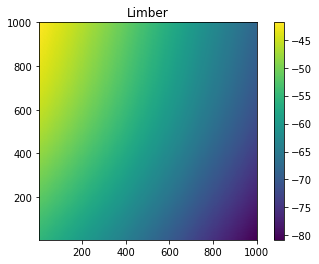

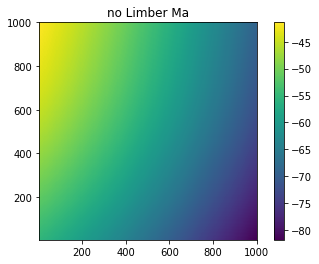

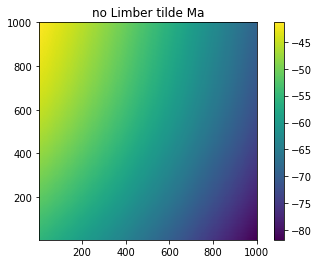

In [27]:
L_, M      = np.load('../output/MLimberSpline_bin_all.npy')
L_         = np.sort(np.unique(L_))

L          = np.logspace(np.log(2),3,200)
M_Limber   = RectBivariateSpline(L_,L_,M)

plt.title('Limber')
plt.imshow(np.log(M_Limber(L,L,grid=True)),extent=(L[0],L[-1],L[0],L[-1]))
plt.colorbar()
plt.show()

M1 = MA22a_spline(L,L,grid=True)
plt.title('no Limber Ma')
plt.imshow(np.log(M1),extent=(L[0],L[-1],L[0],L[-1]))
plt.colorbar()
plt.show()

M2 =tildeMA_spline(L,L,grid=True)
plt.title('no Limber tilde Ma')
plt.imshow(np.log(M2),extent=(L[0],L[-1],L[0],L[-1]))
plt.colorbar()
plt.show()

In [28]:
M = M_Limber(L,L,grid=True)

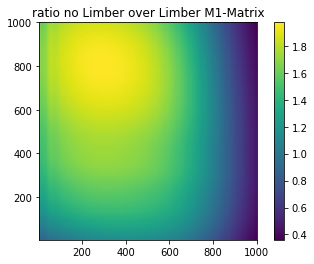

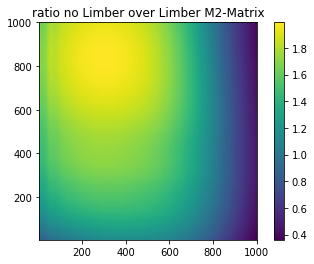

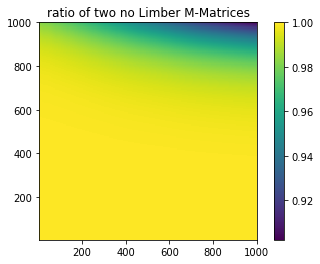

In [29]:
plt.title('ratio no Limber over Limber M1-Matrix')
plt.imshow(M1/M,extent=(L[0],L[-1],L[0],L[-1]))
plt.colorbar()
plt.show()

plt.title('ratio no Limber over Limber M2-Matrix')
plt.imshow(M2/M,extent=(L[0],L[-1],L[0],L[-1]))
plt.colorbar()
plt.show()

plt.title('ratio of two no Limber M-Matrices')
plt.imshow(M1/M2,extent=(L[0],L[-1],L[0],L[-1]))
plt.colorbar()
plt.show()

## Now that we have $M^A$ s: coding this equations
$\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2 [M^{A}( |\vec{L}+\vec{l}|,l)-\tilde{M}^{A}(L,l)] +  \left[\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2-L^2[\vec{L}\cdot \vec{l}]^2\right] \tilde{M}^{A}(L,l)$

In [30]:
def get_regularized_sum_of_terms(L,L1,phi,M1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2+2.*LL1/LL*nu)
            integrand = LL1*(LL**2+LL*LL1*nu)*(LL1**2+LL*LL1*nu)**2*(M1(L_,LL1,grid=False)-M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


#numerical angular integration
def get_second_sum_of_terms(L,L1,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand =  LL1*((LL**2+LL*LL1*nu)*(LL1**2+LL*LL1*nu)**2-LL**2*(LL*LL1*nu)**2)*(M(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

In [31]:
# use same sampling as in Limber case

# sampling for integrations
phi = np.linspace(0.,2.*np.pi,1000,endpoint=True)
L1  = np.logspace(np.log(2),3,400)

In [34]:
MA_spline       = M22a_spline
tildeMA_spline  = tildeMA_spline

begin = time.time()
all_bins = get_regularized_sum_of_terms(L,L1,phi,MA_spline,tildeMA_spline,method='trapz')+get_second_sum_of_terms(L,L1,tildeMA_spline,method='trapz')
print(time.time()-begin)

30.7538838387


In [35]:
sum_Limber =  get_regularized_sum_of_terms(L,L1,phi,M_Limber,M_Limber,method='trapz')+get_second_sum_of_terms(L,L1,M_Limber,method='trapz')

In [36]:
L_, corrs    = np.load('../output/LimberPostBornResultsLSST.npy')
L, corrs_cut = np.load('../output/LimberPostBornResultsLSST_cut.npy')

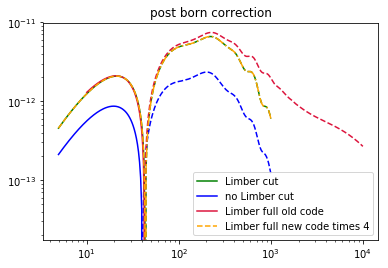

In [37]:
plt.figure()
plt.title('post born correction')
plt.loglog(L,corrs_cut[-1],label='Limber cut',color='g')
plt.loglog(L,-corrs_cut[-1],color='g',ls='--')
plt.loglog(L,all_bins,label='no Limber cut',color='b')
plt.loglog(L,-all_bins,color='b',ls='--')
plt.loglog(L_,corrs[-1],label='Limber full old code',color='crimson')
plt.loglog(L_,-corrs[-1],ls='--',color='crimson')
plt.loglog(L,sum_Limber*4,label='Limber full new code times 4',ls='--',color='orange')
plt.loglog(L,-sum_Limber*4,ls='-.',color='orange')
plt.legend()

array([  2.15561395,   2.15664058,   2.1577162 ,   2.15886131,
         2.16009317,   2.1614218 ,   2.16284555,   2.16434474,
         2.16587889,   2.1674381 ,   2.16904198,   2.17070785,
         2.17244754,   2.17426465,   2.17615778,   2.17814438,
         2.18024555,   2.18247153,   2.18481319,   2.18724403,
         2.18977676,   2.19243594,   2.19523257,   2.19815573,
         2.20120662,   2.20441432,   2.20779169,   2.2113237 ,
         2.21501252,   2.21888864,   2.22295905,   2.22720759,
         2.23166126,   2.23634327,   2.24124138,   2.24637343,
         2.2517694 ,   2.25741866,   2.26334397,   2.2695791 ,
         2.27611847,   2.28299938,   2.29023498,   2.29783076,
         2.30584045,   2.31427344,   2.32318115,   2.33257751,
         2.34250659,   2.35301621,   2.3641542 ,   2.37597425,
         2.38853308,   2.40191265,   2.41620085,   2.43148154,
         2.44788361,   2.46553034,   2.48458979,   2.50523171,
         2.52770127,   2.55228651,   2.57930505,   2.60

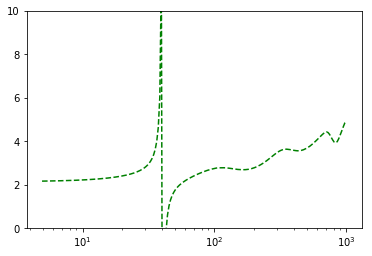

In [39]:
#ration restricted to non-restricted Limber
plt.semilogx(L,corrs_cut[-1]/all_bins,color='g',ls='--')
plt.ylim(0.0,10)

corrs_cut[-1]/all_bins

# additional terms that are zero in Limber

## Eq. 4.2

In [42]:
# scripts are in G matrix notebook
clphipsi   = np.swapaxes(np.load('../G_matrices/clphipsi.npy'),1,2)
cldeltaphi = np.load('../G_matrices/clphidelta.npy')

In [45]:
kernel1 = lsst_kernel
kernel2 = lensing_kernel

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)

result = np.zeros((len(ell_),len(ell_)))
for ii in range(len(ell_)):
    for jj in range(len(ell_)):
        result[ii][jj] = np.sum(w11*w12*chi_cmb**2*kernel1(r2d*chi_cmb)*kernel2(t2d*chi_cmb)*cldeltaphi[ii]*clphipsi[jj])/4.
        
M22b = result

# first inex is L-l, second index is l
np.save('../M_matrices/M22b_%s.npy'%str(file_ext),[np.meshgrid(ell_),M22b])

M22b_spline = RectBivariateSpline(ell_,ell_,M22b)

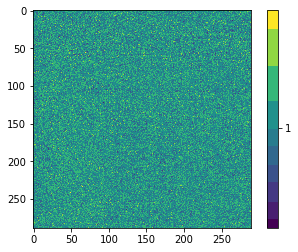

In [55]:
plt.imshow(M22b)
plt.colorbar()

In [48]:
clphipsi_diag = np.zeros((len(ell_),len(t_)))
for ii in range(len(t_)):
    clphipsi_diag[:,ii]=clphipsi[:,ii,ii]

clphipsi_diag_blown=np.zeros((len(ell_),len(t_),len(t_)))
for ii in range(len(t_)):
    clphipsi_diag_blown[:,ii]=clphipsi_diag


In [49]:
cldeltaphi=cldeltaphi.swapaxes(1,2)


kernel1 = lsst_kernel
kernel2 = lensing_kernel

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)

result = np.zeros((len(ell_),len(ell_)))
for ii in range(len(ell_)):
    for jj in range(len(ell_)):
        result[ii][jj] = np.sum(w11*w12*kernel1(t2d*chi_cmb)*kernel2(r2d*chi_cmb)*clphipsi_diag_blown[jj]*cldeltaphi[ii])
result*=chi_cmb**2/4.

M31Ab = result

# first index is L
np.save('../M_matrices/M31Ab_%s.npy'%file_ext,[np.meshgrid(ell_),M31Ab])

M31Ab_spline = RectBivariateSpline(ell_,ell_,M31Ab)

In [53]:
def get_regularized_sum_of_terms_2(L,L1,phi,M1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2+2.*LL1/LL*nu)
            integrand = -LL*LL1*nu*(LL*LL1*nu-LL1**2)**2*LL1*(M1(L_,LL1,grid=False)-M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


#numerical angular integration
def get_second_sum_of_terms_2(L,L1,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand =  LL1*(((LL*LL1*nu)**2*LL1**2)+LL*LL1*nu*(LL*LL1*nu-LL1**2)**2)*(M(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

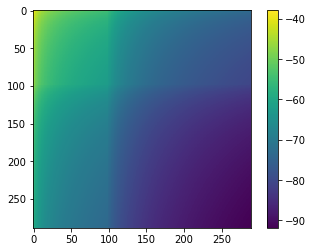

In [54]:
plt.imshow(np.log(M31Ab))
plt.colorbar()

In [55]:
all_bins2 = get_regularized_sum_of_terms_2(L,L1,phi,M22b_spline,M31Ab_spline,method='trapz')+get_second_sum_of_terms_2(L,L1,M31Ab_spline,method='trapz')

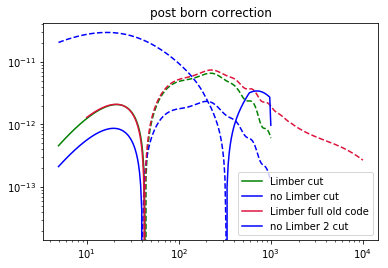

In [56]:
plt.figure()
plt.title('post born correction')
plt.loglog(L,corrs_cut[-1],label='Limber cut',color='g')
plt.loglog(L,-corrs_cut[-1],color='g',ls='--')
plt.loglog(L,all_bins,label='no Limber cut',color='b')
plt.loglog(L,-all_bins,color='b',ls='--')
plt.loglog(L_,corrs[-1],label='Limber full old code',color='crimson')
plt.loglog(L_,-corrs[-1],ls='--',color='crimson')
plt.loglog(L,all_bins2,label='no Limber 2 cut',color='b')
plt.loglog(L,-all_bins2,color='b',ls='--')
plt.legend()